In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [20]:
with open("examples/examp7.txt") as file:
    coordinates = []
    raw_data = []
    for i, line in enumerate(file):
        c, d = line.split("; ")
        coordinates.append([float(number) for number in c.split(", ")])
        raw_data.append([float(number) for number in d.split(", ")])
    coords = np.array(coordinates)
    data = np.array(raw_data)

In [21]:
def calculate_measurement(coords, data):
    x, y, rot = coords
    angle = np.linspace(-2*np.pi/3, 2*np.pi/3, len(data))
    data[data == 5.6] = np.nan
    data[data < 0.3] = np.nan
    xs = np.array([x + data * np.cos(rot-angle)]).transpose()
    ys = np.array([y + data * np.sin(rot-angle)]).transpose()
    points = np.hstack((xs, ys))
    points = points[~np.isnan(points).any(axis=1)]
    return points

In [22]:
all_points = np.vstack([calculate_measurement(c, d) for c, d in zip(coords, data)])
all_points.shape

(54291, 2)

Original measurements

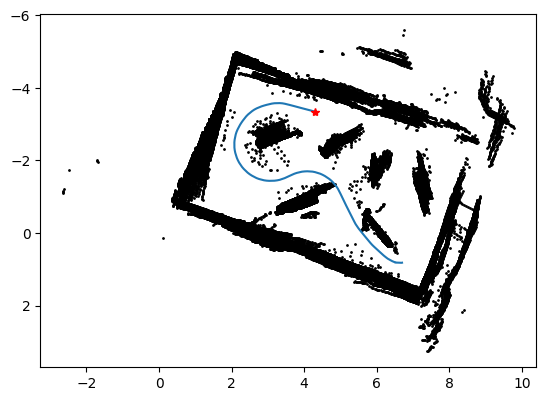

In [23]:
# plt.figure(figsize=(15, 15))
plt.gca().invert_yaxis()
plt.scatter(*all_points.transpose(), c='k', s=1)
plt.plot(*coords.transpose()[:2])
plt.plot(*coords.transpose()[:2, 0], "*", c="r")
plt.gca().set_aspect('equal')

Cell decomposition

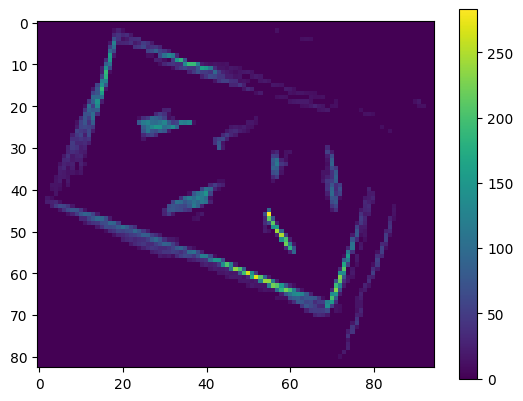

In [24]:
SCALE = 0.1     # размер клетки
TRESHOLD = 10   # мин кол-во измерений, при котором клетка будет считаться препятствием

decomposed = (all_points // np.array([SCALE, SCALE])).astype(np.int16)
decoposed_coords, counts = np.unique(decomposed, axis=0, return_counts=True)
decoposed_coords = decoposed_coords[counts>TRESHOLD]
counts = counts[counts>TRESHOLD]
x_min, y_min, x_max, y_max = *decoposed_coords.min(axis=0), *decoposed_coords.max(axis=0)
size = np.array([x_max - x_min + 5, y_max - y_min + 5])
TOPLEFT = np.array([x_min-2, y_min-2])
cell_map = np.zeros(size, dtype=np.int16)
for coord, n in zip(decoposed_coords, counts):
    cell_map[*(coord-TOPLEFT)] = n
    
plt.imshow(cell_map.transpose())
plt.colorbar()

Bitmap making along with obstacle padding

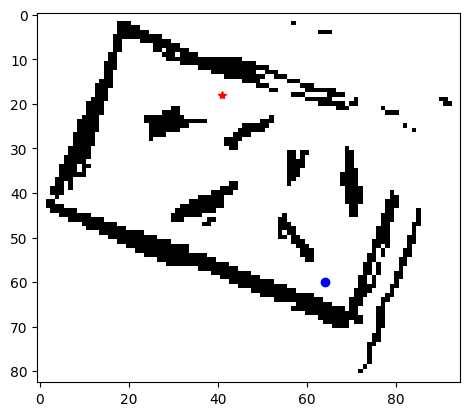

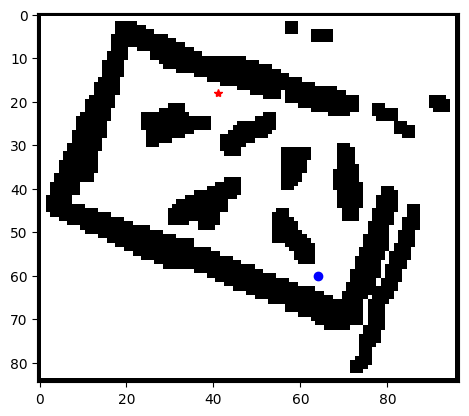

In [25]:
START = (coords[0][:2] // SCALE).astype(np.int16)
FINISH = (coords[-1][:2] // SCALE).astype(np.int16)

ceiled = np.ceil(cell_map)
plt.imshow(~ceiled.transpose().astype(bool), cmap='gray')
plt.plot(*(FINISH-TOPLEFT).transpose(), "o", c="b")
plt.plot(*(START-TOPLEFT).transpose(), "*", c="r")

kernel = np.ones((3, 3))
bitmap = ~cv2.filter2D(ceiled, -1, kernel).astype(bool)
bitmap = np.pad(bitmap, (1, 1), 'constant', constant_values=False)
plt.figure()
plt.imshow(bitmap.transpose(), cmap='gray')
plt.plot(*(FINISH-TOPLEFT).transpose(), "o", c="b")
plt.plot(*(START-TOPLEFT).transpose(), "*", c="r")
np.save('map', bitmap)